## **Classification d'articles d'actualité financière.**



## Introduction
Il y a eu un large éventail d'applications développées au cours de la dernière décennie qui exploitent les données des médias sociaux pour divers objectifs afin d'obtenir des informations significatives.
Les applications les plus importantes et représentatives sont liées au NLP (natural language processing) et l'analyse d'objectivité des différents articles et autres tweets dans le but de classifier des faits et des opinions.

## L'objectif du projet
Nous sommes face à une problématique de classification binaire, il s'agit en effet de créer un classifieur qui pourra déterminer sur des articles financiers, si l'auteur émet une opinion ou bien un fait avéré.

Le projet a été réalisé sur le jeu de données d'articles financiers : "opinion_fact_news.csv" (ce dataset peut contenir des valeurs bruyantes) fourni par l'enseignant.

## Traitement

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import keras
#nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
#nltk.download('stopwords')
#nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.metrics import accuracy_score
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers.embeddings import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf


from keras.models import Sequential
from keras.layers import Input, CuDNNLSTM, Dense
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.layers import Input, CuDNNLSTM, Dense
from keras.layers.embeddings import Embedding
import keras.backend as K

from keras.callbacks import EarlyStopping

from keras.models import Sequential
from keras.layers import Input, CuDNNLSTM, Dense, Bidirectional
from keras.layers.embeddings import Embedding
import keras.backend as K
from sklearn.preprocessing import MinMaxScaler

from tensorflow import keras
from tensorflow.keras import layers

## Initialisation

In [ ]:
df = pd.read_csv("opinion_fact_news_pretraiter.csv")
df = df.drop(columns=["Unnamed: 0"])

In [ ]:
df.head()

,title,body,label
0,bernie sander really happening,watching sander surge front pack race take pre...,opinion
1,london terror attack would much worse assailan...,two people stabbed sunday attack south london ...,opinion
2,super bowl pose question obscene sex sexism,one debate overshadowed rest whether shakira l...,opinion
3,health care trump malicious incompetent yes,democrat debate best path universal health cov...,opinion
4,ever happened head pike story trump republican,adam schiff made reference reporting said conf...,opinion


In [ ]:
df.describe()

,title,body,label
count,10000,10000,10000
unique,8005,9856,2
top,factbox latest coronavirus spreading china beyond,need know understand moment mean us-iran relat...,fact
freq,16,3,5000


In [ ]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   10000 non-null  object
 1   body    10000 non-null  object
 2   label   10000 non-null  object
dtypes: object(3)
memory usage: 234.5+ KB


In [ ]:
df['label'].value_counts()

fact       5000
opinion    5000
Name: label, dtype: int64

## Début du traitement

### Changement des valeurs dans 'label'

In [ ]:
df.loc[df.label == "opinion","label"] = 0
df.loc[df.label == "fact","label"] = 1
df.head(2)

,title,body,label
0,bernie sander really happening,watching sander surge front pack race take pre...,0
1,london terror attack would much worse assailan...,two people stabbed sunday attack south london ...,0


In [ ]:
df.tail(2)

,title,body,label
9998,novartis predicts growth cosentyx zolgensma ad...,file photo company logo seen new cell gene the...,1
9999,russian order watchdog draw plan prevent virus...,file photo russian prime minister mikhail mish...,1


### Séparation des données en 3 sets (train, test, dev)

In [ ]:
features = df.columns[:2]
X = df[features]
Y = df['label']
Y = Y.astype('int')

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=8, stratify= Y)

In [ ]:
print("Taille de notre set de train :")
print("X :",len(X_train),"// Y :",len(Y_train))
print("\nTaille de notre set de test :")
print("X :",len(X_test),"// Y :",len(Y_test))

Taille de notre set de train :
X : 8000 // Y : 8000

Taille de notre set de test :
X : 2000 // Y : 2000


In [ ]:
X_temp = X_test
Y_temp = Y_test
X_test, X_dev, Y_test, Y_dev = train_test_split(X_temp, Y_temp, test_size=0.5)

In [ ]:
print("Taille de notre set de test :")
print("X :",len(X_test),"// Y :",len(Y_test))
print("\nTaille de notre set de dev :")
print("X :",len(X_dev),"// Y :",len(Y_dev))

Taille de notre set de test :
X : 1000 // Y : 1000

Taille de notre set de dev :
X : 1000 // Y : 1000


### Mise en vecteurs des données

#### Bag of Words (BOW ) embedding

In [ ]:
import scipy.sparse as sp
vect = CountVectorizer(ngram_range=(1, 2),analyzer='word', max_features=1000, stop_words='english')
X_train_bow = sp.hstack(X_train.apply(lambda col: vect.fit_transform(col)))
X_train_bow = X_train_bow.toarray()
print("Données de train en vecteur :",X_train_bow.shape)

Données de train en vecteur : (8000, 2000)


In [ ]:
X_test_bow = sp.hstack(X_test.apply(lambda col: vect.transform(col)))
X_test_bow = X_test_bow.toarray()
print("Données de test en vecteur :",X_test_bow.shape)

Données de test en vecteur : (1000, 2000)


In [ ]:
X_dev_bow = sp.hstack(X_dev.apply(lambda col: vect.transform(col)))
X_dev_bow = X_dev_bow.toarray()
print("Données de dev en vecteur :",X_dev_bow.shape)

Données de dev en vecteur : (1000, 2000)


#### Term Frequency-Inverse Document Frequency (TF-IDF) Embedding

In [ ]:
vect = TfidfVectorizer(max_features=1000)

In [ ]:
X_train_tfidf = sp.hstack(X_train.apply(lambda col: vect.fit_transform(col)))
print("Données de train en vecteur :",X_train_tfidf.shape)

Données de train en vecteur : (8000, 2000)


In [ ]:
X_test_tfidf = sp.hstack(X_test.apply(lambda col: vect.transform(col)))
print("Données de test en vecteur :",X_test_tfidf.shape)

Données de test en vecteur : (1000, 2000)


In [ ]:
X_dev_tfidf = sp.hstack(X_dev.apply(lambda col: vect.transform(col)))
print("Données de dev en vecteur :",X_dev_tfidf.shape)

Données de dev en vecteur : (1000, 2000)


Pour chaque words embeding, nous allons utiliser les algorithmes d'apprentissage automatique suivants :
  - SVM
  - KNN

### SVM - Support Vector Classification

SVM donne l'hyperplan qui sépare le mieux les données. Il dessine la marge maximale de l'hyper plan entre deux classes (ici "Fait" et "Opinion").
Nous avons utilisé Grid Search cv pour déterminer les valeurs optimales des hyperparamètres populaires dans SVM qui sont le noyau et « C » (paramètre de régularisation).

In [ ]:
from sklearn.model_selection import GridSearchCV

#### Recherche hyperparamètre BoW

In [ ]:
parameters = {'kernel':('linear', 'rbf','poly','sigmoid'), 'C':[0.0001, 0.001, 0.01, 0.1, 1, 10]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf_result = clf.fit(X_dev_bow, Y_dev)
GridSearchCV(estimator=svc,
             param_grid={'C': parameters['C'], 'kernel': parameters['kernel']})

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'kernel': ('linear', 'rbf', 'poly', 'sigmoid')})

In [ ]:
print(clf.best_params_)

{'C': 0.1, 'kernel': 'linear'}


In [ ]:
for score, param_kernel, param_c in zip(clf.cv_results_['mean_test_score'], clf.cv_results_['param_kernel'], clf.cv_results_['param_C']) :
  print("Param : " + str(param_kernel) + " " + str(param_c) + " | Score : " + str(score));

Param : linear 0.0001 | Score : 0.8230000000000001
Param : rbf 0.0001 | Score : 0.517
Param : poly 0.0001 | Score : 0.517
Param : sigmoid 0.0001 | Score : 0.517
Param : linear 0.001 | Score : 0.9550000000000001
Param : rbf 0.001 | Score : 0.517
Param : poly 0.001 | Score : 0.517
Param : sigmoid 0.001 | Score : 0.517
Param : linear 0.01 | Score : 0.9709999999999999
Param : rbf 0.01 | Score : 0.517
Param : poly 0.01 | Score : 0.525
Param : sigmoid 0.01 | Score : 0.584
Param : linear 0.1 | Score : 0.9829999999999999
Param : rbf 0.1 | Score : 0.833
Param : poly 0.1 | Score : 0.617
Param : sigmoid 0.1 | Score : 0.8620000000000001
Param : linear 1 | Score : 0.9819999999999999
Param : rbf 1 | Score : 0.958
Param : poly 1 | Score : 0.707
Param : sigmoid 1 | Score : 0.967
Param : linear 10 | Score : 0.9819999999999999
Param : rbf 10 | Score : 0.975
Param : poly 10 | Score : 0.767
Param : sigmoid 10 | Score : 0.937


In [ ]:
results = pd.DataFrame(clf.cv_results_)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt 

In [ ]:
d = {0.0001: 1, 0.001: 2, 0.01:3, 0.1:4, 1:5, 10:6}
results['param_C'].replace(d,inplace=True)

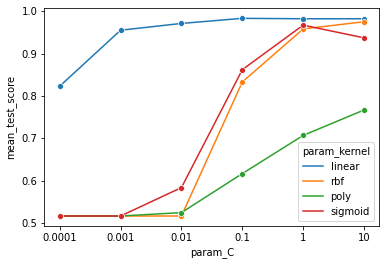

In [ ]:
plt.xticks(range(1,len(parameters['C'])+1), parameters['C'])
sns.lineplot(data=results, x='param_C', y="mean_test_score", hue="param_kernel", marker='o')
plt.show()

#### Prédiction SVM - BoW

In [ ]:
clf = svm.SVC(C=0.1, kernel='linear')
clf.fit(X_train_bow, Y_train)

SVC(C=0.1, kernel='linear')

In [ ]:
Y_predict_bow = clf.predict(X_test_bow)

In [ ]:
accuracy_score(Y_test,Y_predict_bow)

0.993

#### Hyperparamètre TF-IDF

In [ ]:
parameters = {'kernel':('linear', 'rbf','poly','sigmoid'), 'C':[0.0001, 0.001, 0.01, 0.1, 1, 10]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf_result = clf.fit(X_dev_tfidf, Y_dev)
GridSearchCV(estimator=svc,
             param_grid={'C': parameters['C'], 'kernel': parameters['kernel']})

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'kernel': ('linear', 'rbf', 'poly', 'sigmoid')})

In [ ]:
for score, param_kernel, param_c in zip(clf.cv_results_['mean_test_score'], clf.cv_results_['param_kernel'], clf.cv_results_['param_C']) :
  print("Param : " + str(param_kernel) + " " + str(param_c) + " | Score : " + str(score));

Param : linear 0.0001 | Score : 0.517
Param : rbf 0.0001 | Score : 0.517
Param : poly 0.0001 | Score : 0.517
Param : sigmoid 0.0001 | Score : 0.517
Param : linear 0.001 | Score : 0.517
Param : rbf 0.001 | Score : 0.517
Param : poly 0.001 | Score : 0.517
Param : sigmoid 0.001 | Score : 0.517
Param : linear 0.01 | Score : 0.534
Param : rbf 0.01 | Score : 0.517
Param : poly 0.01 | Score : 0.517
Param : sigmoid 0.01 | Score : 0.517
Param : linear 0.1 | Score : 0.961
Param : rbf 0.1 | Score : 0.8530000000000001
Param : poly 0.1 | Score : 0.517
Param : sigmoid 0.1 | Score : 0.9470000000000001
Param : linear 1 | Score : 0.986
Param : rbf 1 | Score : 0.982
Param : poly 1 | Score : 0.9270000000000002
Param : sigmoid 1 | Score : 0.984
Param : linear 10 | Score : 0.985
Param : rbf 10 | Score : 0.985
Param : poly 10 | Score : 0.875
Param : sigmoid 10 | Score : 0.9739999999999999


In [ ]:
print(clf.best_params_)

{'C': 1, 'kernel': 'linear'}


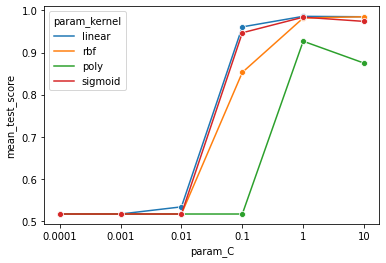

In [ ]:
results = pd.DataFrame(clf.cv_results_)
d = {0.0001: 1, 0.001: 2, 0.01:3, 0.1:4, 1:5, 10:6}
results['param_C'].replace(d,inplace=True)
plt.xticks(range(1,len(parameters['C'])+1), parameters['C'])
sns.lineplot(data=results, x='param_C', y="mean_test_score", hue="param_kernel", marker='o')
plt.show()

En utilisant, le word embeding TF-IDF, les meilleurs paramètres pour le SVC sont un noyau lineaire et C = 1.

#### Prédiction SVM - TF-IDF

In [ ]:
clf = svm.SVC(kernel='linear',C=1)
clf.fit(X_train_tfidf, Y_train)

SVC(C=1, kernel='linear')

In [ ]:
Y_predict_tfidf = clf.predict(X_test_tfidf)

In [ ]:
accuracy_score(Y_test,Y_predict_tfidf)

0.988

### KNN - k plus proches voisins

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

#### Avec Bow : 

In [ ]:
parameters = {'n_neighbors': [1,2,3,4,5,6,7,8,9]}
clf = GridSearchCV(KNeighborsClassifier(), parameters, scoring="accuracy")
clf_result = clf.fit(X_train_bow, Y_train)
GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors':parameters['n_neighbors']})

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9]})

In [ ]:
for score, param_n in zip(clf.cv_results_['mean_test_score'], clf.cv_results_['param_n_neighbors']) :
  print("Param : " + str(param_n) + " | Score : " + str(score));

Param : 1 | Score : 0.939875
Param : 2 | Score : 0.937375
Param : 3 | Score : 0.9397499999999999
Param : 4 | Score : 0.944
Param : 5 | Score : 0.9372499999999999
Param : 6 | Score : 0.9470000000000001
Param : 7 | Score : 0.93025
Param : 8 | Score : 0.939625
Param : 9 | Score : 0.925


In [ ]:
print(clf_result.best_params_)

{'n_neighbors': 6}


In [ ]:
accuracy = dict()
recall = dict()
f1score = dict()
precision = dict()
res = dict()
for n in parameters['n_neighbors'] : 
  clf = KNeighborsClassifier(n_neighbors=n)
  clf.fit(X_train_bow, Y_train)
  predict = clf.predict(X_test_bow)
  accuracy[n] = accuracy_score(Y_test,predict)
  recall[n] = recall_score(Y_test,predict)
  f1score[n] = f1_score(Y_test,predict)
  precision[n] = precision_score(Y_test,predict)

In [ ]:
results = pd.DataFrame(accuracy.values(), index=accuracy.keys(), columns=["Accuracy"])
results['Precision'] = precision.values()
results['Recall'] = recall.values()
results['F1-Score'] = f1score.values()
results

,Accuracy,Precision,Recall,F1-Score
1,0.934,0.929524,0.943907,0.936660
2,0.934,0.972746,0.897485,0.933602
3,0.943,0.942308,0.947776,0.945034
4,0.943,0.963710,0.924565,0.943731
5,0.942,0.927374,0.963250,0.944972
6,0.946,0.953033,0.941973,0.947471
7,0.942,0.921101,0.970986,0.945386
8,0.947,0.937736,0.961315,0.949379
9,0.943,0.918182,0.976789,0.946579
10,0.946,0.931099,0.967118,0.948767


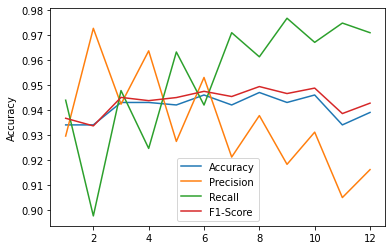

In [ ]:
sns.lineplot(data=results, x=results.index, y="Accuracy", label="Accuracy")
sns.lineplot(data=results, x=results.index, y="Precision", label="Precision")
sns.lineplot(data=results, x=results.index, y="Recall", label="Recall")
sns.lineplot(data=results, x=results.index, y="F1-Score", label="F1-Score")
plt.show()

#### Avec TF-IDF :

In [ ]:
parameters = {'n_neighbors': [1,2,3,4,5,6,7,8,9]}
clf = GridSearchCV(KNeighborsClassifier(), parameters, scoring="accuracy")
clf_result = clf.fit(X_train_tfidf, Y_train)
GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors':parameters['n_neighbors']})

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9]})

In [ ]:
print(clf_result.best_params_)

{'n_neighbors': 1}


In [ ]:
accuracy = dict()
recall = dict()
f1score = dict()
precision = dict()
res = dict()
for n in parameters['n_neighbors'] : 
  clf = KNeighborsClassifier(n_neighbors=n)
  clf.fit(X_train_tfidf, Y_train)
  predict = clf.predict(X_test_tfidf)
  accuracy[n] = accuracy_score(Y_test,predict)
  recall[n] = recall_score(Y_test,predict)
  f1score[n] = f1_score(Y_test,predict)
  precision[n] = precision_score(Y_test,predict)

results = pd.DataFrame(accuracy.values(), index=accuracy.keys(), columns=["Accuracy"])
results['Precision'] = precision.values()
results['Recall'] = recall.values()
results['F1-Score'] = f1score.values()
results

,Accuracy,Precision,Recall,F1-Score
1,0.902,0.977221,0.829787,0.897490
2,0.827,0.988636,0.673114,0.800921
3,0.877,0.978155,0.779497,0.867600
4,0.828,0.991453,0.673114,0.801843
5,0.866,0.987277,0.750484,0.852747
6,0.821,0.997059,0.655706,0.791132
7,0.850,0.997290,0.711799,0.830700
8,0.814,0.996997,0.642166,0.781176
9,0.834,0.994366,0.682785,0.809633


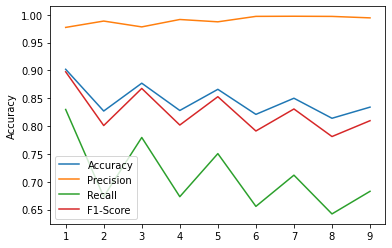

In [ ]:
sns.lineplot(data=results, x=results.index, y="Accuracy", label="Accuracy")
sns.lineplot(data=results, x=results.index, y="Precision", label="Precision")
sns.lineplot(data=results, x=results.index, y="Recall", label="Recall")
sns.lineplot(data=results, x=results.index, y="F1-Score", label="F1-Score")
plt.show()

## Réseaux de neurones

Nous avons ensuite implémenté des réseaux de neurones, cf [reseaux_neurones](reseaux_neurones.ipynb), et enregistré les résultats dans un fichier texte. En effet, le code étant assez lourd et peu digeste, nous avons décidé de séparer celui-ci de son étude qui va suivre.

In [ ]:
data = pd.read_csv('resultat.txt',sep=',')

In [ ]:
data

,Nom,Nombre d'itérations,Dropout,Precision,Rappel,Score-F1,Accuracy,Tps appr (ms),Tps test (ms),Mem test(bit),nbr param,Taille(bit)
0,Deep_Neural_Network,20,0.0,0.990,0.9915,0.9915,0.9915,41481,335,2345,1883137,4096
1,Deep_Neural_Network,20,0.2,0.990,0.9925,0.9925,0.9925,82596,350,23438,1883137,4096
2,Deep_Neural_Network,20,0.5,0.988,0.9920,0.9920,0.9920,82573,358,23438,1883137,4096
3,Deep_Neural_Network,20,0.8,0.991,0.9930,0.9930,0.9930,82594,356,25789,1883137,4096
4,LSTM,20,0.0,0.987,0.9905,0.9905,0.9905,133330,1104,23438,885505,4096
5,LSTM,20,0.2,0.992,0.9905,0.9905,0.9905,140251,1131,32825,885505,4096
6,LSTM,20,0.5,0.989,0.9910,0.9910,0.9910,141234,1117,23438,885505,4096
7,LSTM,20,0.8,0.991,0.9910,0.9910,0.9910,140077,1136,23438,885505,4096
8,GRU,20,0.0,0.977,0.9846,0.9845,0.9845,27414,258,46875,127489,4096
9,GRU,20,0.2,0.985,0.9870,0.9870,0.9870,27724,254,46875,127489,4096


In [ ]:
reseaux = pd.unique(data["Nom"]).tolist()
reseaux

['Deep_Neural_Network', 'LSTM', 'GRU', 'BRNN', 'RCNN']

In [ ]:
bestRes = list()
for reseau in reseaux :
    tmp = data[data["Nom"] == reseau]
    bestRes.append(tmp[tmp["Accuracy"].max() == tmp["Accuracy"]])

### DNN

In [ ]:
bestRes[0]

,Nom,Nombre d'itérations,Dropout,Precision,Rappel,Score-F1,Accuracy,Tps appr (ms),Tps test (ms),Mem test(bit),nbr param,Taille(bit)
3,Deep_Neural_Network,20,0.8,0.991,0.993,0.993,0.993,82594,356,25789,1883137,4096


### LSTM

In [ ]:
bestRes[1]

,Nom,Nombre d'itérations,Dropout,Precision,Rappel,Score-F1,Accuracy,Tps appr (ms),Tps test (ms),Mem test(bit),nbr param,Taille(bit)
6,LSTM,20,0.5,0.989,0.991,0.991,0.991,141234,1117,23438,885505,4096
7,LSTM,20,0.8,0.991,0.991,0.991,0.991,140077,1136,23438,885505,4096


In [ ]:
bestRes[1] = bestRes[1][bestRes[1].Precision.max() == bestRes[1].Precision]

In [ ]:
bestRes[1]

,Nom,Nombre d'itérations,Dropout,Precision,Rappel,Score-F1,Accuracy,Tps appr (ms),Tps test (ms),Mem test(bit),nbr param,Taille(bit)
7,LSTM,20,0.8,0.991,0.991,0.991,0.991,140077,1136,23438,885505,4096


### GRU

In [ ]:
bestRes[2]

,Nom,Nombre d'itérations,Dropout,Precision,Rappel,Score-F1,Accuracy,Tps appr (ms),Tps test (ms),Mem test(bit),nbr param,Taille(bit)
9,GRU,20,0.2,0.985,0.987,0.987,0.987,27724,254,46875,127489,4096


### BRNN

In [ ]:
bestRes[3]

,Nom,Nombre d'itérations,Dropout,Precision,Rappel,Score-F1,Accuracy,Tps appr (ms),Tps test (ms),Mem test(bit),nbr param,Taille(bit)
12,BRNN,20,0.0,0.988,0.9905,0.9905,0.9905,55763,418,46875,582913,4096
13,BRNN,20,0.2,0.987,0.9905,0.9905,0.9905,56218,408,46875,582913,4096


In [ ]:
bestRes[3] = bestRes[3][bestRes[3].Precision.max() == bestRes[3].Precision]

In [ ]:
bestRes[3]

,Nom,Nombre d'itérations,Dropout,Precision,Rappel,Score-F1,Accuracy,Tps appr (ms),Tps test (ms),Mem test(bit),nbr param,Taille(bit)
12,BRNN,20,0.0,0.988,0.9905,0.9905,0.9905,55763,418,46875,582913,4096


### RCNN

In [ ]:
bestRes[4]

,Nom,Nombre d'itérations,Dropout,Precision,Rappel,Score-F1,Accuracy,Tps appr (ms),Tps test (ms),Mem test(bit),nbr param,Taille(bit)
18,RCNN,20,0.5,0.988,0.99,0.99,0.99,85967,375,46875,582913,4096


### Graphe de chaque réseau de neurones :

Pour chaque type de réseau de neurone, on va comparer graphiquement l'accuracy, la précision, le rappel et le f1-score avec un dropout qui diffère (0, 0.2, 0.5, 0.8).  
On remarque que pour chaque modèle nos valeurs d'accuracy, précision etc.. ne changent pas beaucoup, elles sont pratiquement les mêmes, ce qui montre que ce modèle est stable.   
La valeur de l'accuracy ne change pas beaucoup selon la valeur du dropout.

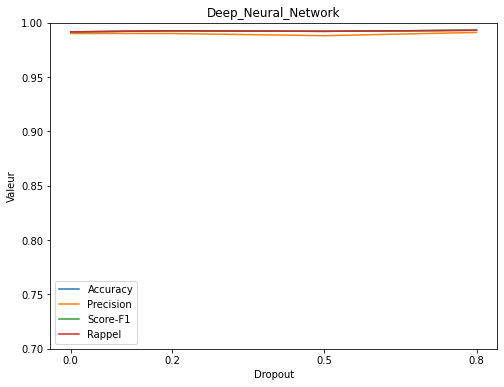

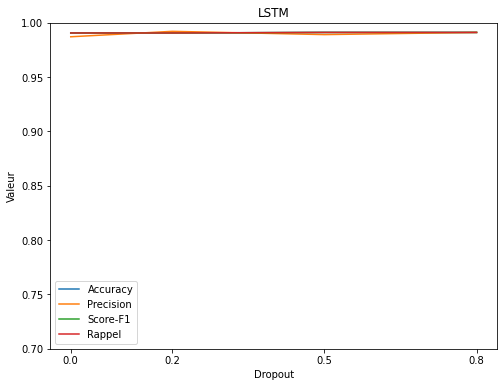

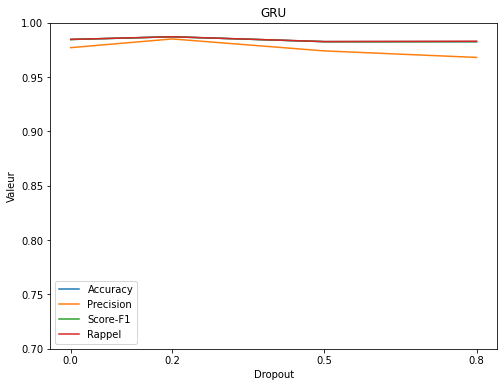

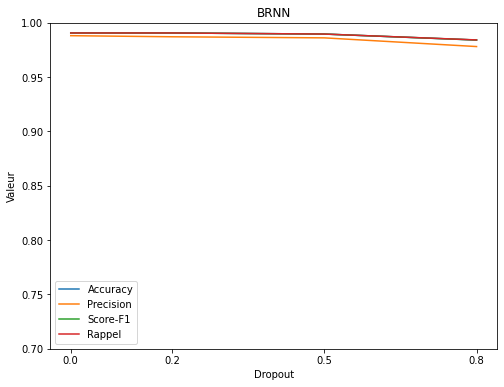

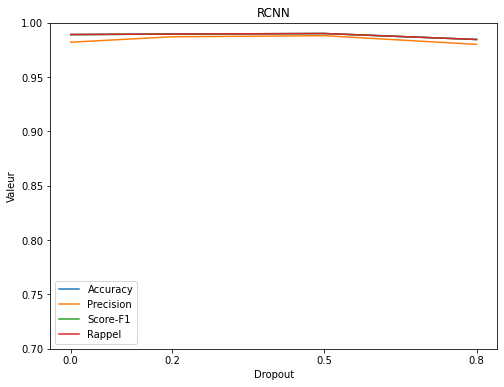

In [ ]:
for nn in reseaux :
  tmp = data[data["Nom"] == nn]
  plt.figure(figsize=(8, 6))
  plt.xticks([0,0.2,0.5,0.8])
  plt.ylim(ymax=1)
  plt.ylim(ymin=0.7)
  sns.lineplot(x=tmp.Dropout, y=tmp.Accuracy, label="Accuracy")
  sns.lineplot(x=tmp.Dropout, y=tmp.Precision,label="Precision")
  sns.lineplot(x=tmp.Dropout, y=tmp['Score-F1'],label="Score-F1")
  sns.lineplot(x=tmp.Dropout, y=tmp.Rappel,label="Rappel")
  plt.ylabel("Valeur")
  plt.title(nn)
  plt.show()

#### Comparaison de chaque meilleurs réseau de neurone :

In [ ]:
bestRes[0].columns

Index(['Nom', 'Nombre d'itérations', 'Dropout', 'Precision', 'Rappel',
       'Score-F1', 'Accuracy', 'Tps appr (ms)', 'Tps test (ms)',
       'Mem test(bit)', 'nbr param', 'Taille(bit)'],
      dtype='object')

In [ ]:
nn_best_accuracy = dict()
nn_nb_param = dict()
nn_time = dict()
for br in bestRes:
  nn_best_accuracy[list(br['Nom'])[0]] = list(br['Accuracy'])[0]
  nn_nb_param[list(br['Nom'])[0]] = list(br['nbr param'])[0]
  nn_time[list(br['Nom'])[0]] = list(br['Tps test (ms)'])[0]

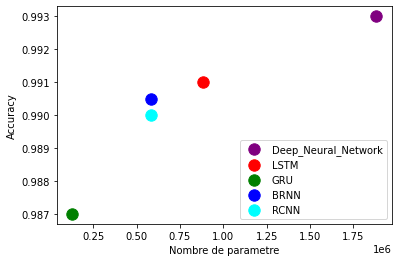

In [ ]:
legend = dict()
legend_color = ['purple', 'red', 'green', 'blue', 'cyan']
i = 0
for reseau in reseaux:
  legend[reseau] = plt.scatter(nn_nb_param[reseau], nn_best_accuracy[reseau], s = 130, c = legend_color[i], marker = 'o')
  i+=1
plt.xlabel("Nombre de parametre")
plt.ylabel("Accuracy")
plt.legend(legend.values(),
           legend.keys())

Le modèle DNN est celui qui a la meilleure accuracy mais c'est également celui qui utilise le plus de paramètres. De ce fait, on préfère choisir le modèle LSTM, qui est le deuxième modèle qui a le plus d'accuracy avec 885505 paramètres.

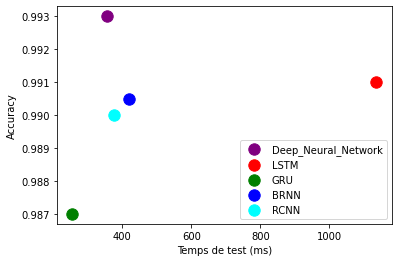

In [ ]:
legend = dict()
legend_color = ['purple', 'red', 'green', 'blue', 'cyan']
i = 0
for reseau in reseaux:
  legend[reseau] = plt.scatter(nn_time[reseau], nn_best_accuracy[reseau], s = 130, c = legend_color[i], marker = 'o')
  i+=1
plt.xlabel("Temps de test (ms)")
plt.ylabel("Accuracy")
plt.legend(legend.values(),
           legend.keys())

Le modèle DNN est celui qui a une meilleur accuracy et il prend également peu de temps pour prédire le dataset comparé à LSTM.

On conclut que le meilleurs modèle de réseau de neurone qu'on utiliser pour predir le dataset est DNN avec un dropout à 0.8 et valeur d'iterations egals a 20. Des informations détaillées sur les layers de ce modèle que je voudrais montrer ci-dessous.

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
model=tf.keras.models.load_model("/content/DNN")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300)]             0         
                                                                 
 dense (Dense)               (None, 1024)              308224    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 1,883,137
Trainable params: 1,883,137
Non-train